The shooting method:

For solving the general system
$$
    U' = (U_1, F(U_0))
    \qquad
    U_0(0) = u_0
    \qquad
    U_0(1) = u_1.
$$
Consider the PVI
$$
    W' = (W_1, F(W_0)) \qquad W(0) = (u_0, a).
$$
We want to choose $a$ so that $W_0(1; a) = u_1$. Iteratively search $a_k \to a$ by newton's method
$$
    u_1 = W_0(1;a_{k+1}) \approx W_0(1; a_{k}) + (a_{k+1}-a_{k}) \partial_{a} W_0(1, a_k)
    \\
    \implies
    a_{k+1} = a_{k} - \partial_a W_0(1; a)^{-1} (W_0(1;a) - u_1).
$$
Introduce $V = \partial_a W = (\partial_a W_0, \partial_a W_1) = (V_0, V_1)$. Then,
$$
    V' = (\partial_a W_1, \partial_a F(W_0)) = (V_1, DF(W_0(t; a)) V_0)
    \qquad
    V(0) = (0, 1).
$$
In summary, to solve de BVP we follow the algorithm:

1. Set an initial guess $a_0$.
2. Solve $W$ for that $a_0$
3. Use $W$ to solve for $V$
4. Update $a$

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def rk3_system(x0: np.array, h: float, t_min: float, t_max: float, f: callable):
    xn = x0
    tn = t_min
    steps = [x0]
    while tn < t_max:
        xi1 = xn
        xi2 = xn + (2/3) * h * f(tn + (2/3)*h, xi1)
        xi3 = xn + (2/3) * h * f(tn + (2/3)*h, xi2)
        
        xn = xn + h * ((1/4)*f(tn,xi1) + (3/8)*f(tn + (2/3)*h, xi2) + (3/8)*f(tn + (2/3)*h, xi3))
        tn = tn + h
        steps.append(xn)
    return np.array(steps)

In [3]:
def shoot(u0, u1, a0, tmin, tmax, dt, F: callable, DF: callable, max_iter):
    a_next = a0
    n_iter = 0
    while n_iter <= max_iter:
        a_prev = a_next
    
        #  Solve W
        W0 = np.array([u0, a_prev])
        def wF(t, W): return np.array([W[1], F(t, W[0])])
        W = rk3_system(W0, dt, tmin, tmax, wF)

        if abs(W[-1, 0] - u1) <= 1e-8:
            return W, a_next
        
        #  Solve V
        def DFW(t): return DF(0, W[int(t * W.shape[0]), 0])
        def vF(t, V, W=W): return np.array([V[1], DFW(t) * V[0]])
            
        V0 = np.array([0, 1])
        V = rk3_system(V0, dt, tmin, tmax, vF)

        #  Update a
        a_next = a_prev - (W[-1,0] - u1) / V[-1, 0]

        n_iter += 1
    
    if n_iter >= max_iter:
        raise Exception('Failed to converged.')

In [4]:
lmbda = 9
def Y(t): return np.sin(2*np.pi*t)

def F(t, U0):
    return -lmbda*(U0**3 - U0) + Y(t)

def DF(t, U0):
    return -lmbda*(3*U0**2 - np.ones_like(U0))

In [7]:
u0, u1 = 0.0, 0.0
tmin, tmax = 0.0, 1.0
a0 = 5.0
dt = (tmax-tmin) / 100

U, a = shoot(u0, u1, a0, tmin, tmax, dt, F, DF, 100)

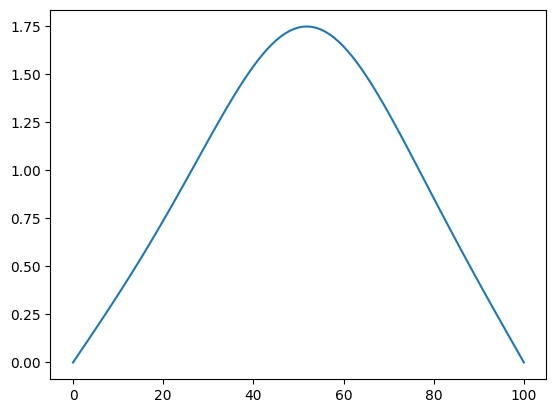

In [8]:
plt.plot(U[:, 0])
plt.show()